# Homework #3 (Due 10/2/2019, 11:59pm)
## EM for Data Augmentation; MCMC Sampling

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Ian Weaver**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
# Mount working directory
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/class/am207/HW3

### Import basic libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn as sk
import scipy as st
import time

from sklearn.linear_model import LinearRegression
from collections import namedtuple

### Plot configs
%matplotlib inline
%config InlineBackend.figure_format = "retina"
sns.set(style="darkgrid", palette="colorblind", color_codes=True)
fig_wide = (11, 4)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/class/am207/HW3


---

# Problem Description: Latent Variables for Data Augmentation

A botany research lab in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to study the genetic factor that creates an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each. 

Out of 197 initial cross-breedings, the nursery obtained the following counts of the four types of child plants:

$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$

where $y_i$ represents the number of child plants that are of type $i$.

The geneticist in the lab know that the probability of obtaining each type of child plant in any single breeding experiment is correlated by the inheritability $\theta$ of a specific genetic factor. That is, the probabilities of obtaining the four subtypes are as follows:

$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4},$$

where $\theta \in [0, 1]$ is unknown.

The lab chose to model the observed data using a multinomial model:

\begin{align}
Y & \sim Mult\left(197, \left[\frac{\theta+2}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{align}

The aim of this problem is to estimate $\theta$ from the observed counts.

## Part I: MLE Through Latent Variable Augmentation and EM
In models where directly computing the MLE is hard (you can think about if that is the case here), the optimization of the likelihood can often be simplified by introducing a latent variable into the model and then optimize the liklelihood using EM - this process is called ***data augmentation***.

The nursery augmented the data with a new variable $Z$ such that:
$$Z + (y_1 - Z) = y_1.$$
That is, using $Z$, they are breaking $y_1$, the number of Type I child plants, into two subtypes, with $Z$ being the count of Subtype #1 and $(y_1-Z)$ being the count of Subtype #2. The lab posited the probability of obtaining the two subtypes to be $\theta/4$ and $1/2$, respectively.

The augmented model (which includes the observed data $y$ and the latent variable $Z$ they introduced) they derived is as follows:

\begin{aligned}
Z | Y, \theta &\sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)\\
Y & \sim Mult\left(197, \left[\frac{1}{2} + \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{aligned}

1. Show that the assumptions the lab made about $Z$ implies that $Z | Y, \theta \sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)$.<br><br>

2. Derive the EM updates for the augmented latent variable model.<br><br>

3. Implement the EM algorithm to estimate the MLE of $\theta$. Choose an appropriate initialization point and an appropriate stopping condition.<br><br>

4. Explain the potential advantage of augmenting likelihood models with a latent variable (e.g. what aspects of the MLE computation becomes easier or more efficient?).

### 1.1 $Z | Y, \theta \sim$ Binomial proof

From the definition of joint probability we have
$\newcommand{\|}{\ |\ }$
\begin{align}
    p(Z \| Y,\theta) = \frac{p(Z,Y\|\theta)}{p(Y \| \theta)} 
    = \frac{{y_1 \choose Z}\left( \frac{\theta}{4} \right)^Z 
    \left( \frac{1}{2} \right)^{y_1 - Z}
    \left( \frac{1 - \theta}{4} \right)^{y_2 + y_3}
    \left( \frac{\theta}{4}\right)^{y_4}}
    {\left( \frac{2+\theta}{4} \right)^{y_1} 
    \left( \frac{1 - \theta}{4} \right)^{y_2 + y_3}
    \left( \frac{\theta}{4}\right)^{y_4}} \quad,
\end{align}

where the Multinomial coefficient in the denominator is omitted because it does not affect the final proportionality. Cancelling out the remaining terms and subbing in 
$y_1 \equiv Z + (y_1 - Z)$ into the denominator,

\begin{align}
    p(Z \| Y,\theta) &= \frac{{y_1 \choose Z}\left( \frac{\theta}{4} \right)^Z
    \left( \frac{1}{2} \right)^{y_1 - Z}}
    {\left( \frac{2+\theta}{4} \right)^{Z + (y_1 - Z)}} \\
    &= {y_1 \choose Z} \left( \frac{\theta}{2 + \theta} \right)^Z
    \left[ \frac{4}{2(2 + \theta)} \right]^{y_1 - Z} \\
    &= {y_1 \choose Z} \left( \frac{\theta}{2 + \theta} \right)^Z
    \left( \frac{2}{2 + \theta} \right)^{y_1 - Z} \\
    &= {y_1 \choose Z} \left( \frac{\theta}{2 + \theta} \right)^Z
    \left( 1 - \frac{\theta}{2 + \theta} \right)^{y_1 - Z} \\
    &= \boxed{Bin\left( y_1, \frac{\theta}{2 + \theta} \right)} \quad.
\end{align}

With a little bit of massaging, the introduction of $Z$ allowed us to work with a Binomial distribution!

### 1.2 EM updates derivation

Say we have a general log-likelihood function $\ln p(X|\theta)$ that we want to maximize, but it's really hard to do. The EM method helps us find a simpler function $\mathcal L(\theta, q)$ (where $q$ is a weight on our latent variable $t$) that is guaraneteed to be less than or equal to our more complex $\ln p(X|\theta)$ via Jensen's inequality. Maximizing this simpler function then gives us a lower bound on the maximial location of our more complex function that we wanted to optimize in the first place. Let's find out what this simpler function
$\mathcal L(\theta, q)$ looks like for $N$ data points with $k$ categories.

\begin{align}
    \ln p(X \| \theta) = \sum_{n=1}^N\ln p(x_n|\theta) = 
    \sum_{n=1}^N \ln \sum_{c=1}^k p(x_n, t_n = c \| \theta) \quad,
\end{align}

where $p(x_n\ |\ \theta) = \sum_{c=1}^k p(x_n, t_n = c \| \theta)$ is just the law of total probability for our latent variable. Continuing, we have

\begin{align}
    \ln p(X \| \theta) 
    &= \sum_{n=1}^N \ln\sum_{c=1}^k
    \frac{q(t_n=c)}{q(t_n=c)}p(x_n,t_n=x \| \theta),& \text{multiplied by 1} \\
    &\ge \sum_{n=1}^N\sum_{c=1}^k q(t_n=c)\ln
    \frac{p(x_n,t_n=c \| \theta)}{q(t_n=c)},& \text{applied Jensen's inequality}
    \\
    &\equiv \mathcal{L(\theta, q)} \quad.
\end{align}

We now have our hopefully simpler function to try and maximize over, which can be done in two steps: the E-step and the M-step.

The idea is to hold $\theta$ fixed first and maximize over $q$ (E-step), then
hold $q$ fixed and maximize over $\theta$ (M-step). Because $\mathcal L(\theta, q)$ is guaranteed to be less than or equal to $\ln p(X \| \theta)$ via Jensen's inequality, iterating $I$ times between these steps will hopefully take us near the maximal location in $p(X \| \theta)$. Let's start with the E-step.

#### E-step

To maximize $\mathcal L(\theta, q)$, let's look at the gap $(GAP)$ between $\ln p(X \| \theta)$ and $\mathcal L (\theta, q)$. If we maximize $L (\theta, q)$, then this will minimize

\begin{align}
    GAP &= \ln p(X \| \theta) - \mathcal L (\theta, q) \\
        &= \sum_{n=1}^N\ln p(x_n |\ \theta) - 
        \sum_{n=1}^N\sum_{c=1}^k q(t_n=c)
        \ln\frac{p(x_n,t_n=c \| \theta)}{q(t_n=c)} \\
    &= \sum_{n=1}^N\left[ \ln p(x_n \| \theta) \cdot \sum_{c=1}^k q(t_n=c)
       - \sum_{n=1}^N\sum_{c=1}^k q(t_n=c)
       \ln\frac{p(x_n,t_n=c \| \theta)}{q(t_n=c)} \right], & 
       \text{used } \sum_{c=1}^k q(t_n=c) = 1 \\
    &= \sum_{n=1}^N \sum_{c=1}^k q(t_n=c)\left[ 
       \ln p(x_n \| \theta)  
       - \ln\frac{p(x_n,t_n=c \| \theta)}{q(t_n=c)} \right], &
       \text{factored out } \sum_{c=1}^k q(t_n=c) \\
    &= \sum_{n=1}^N\sum_{c=1}^k q(t_n=c)
       \ln\frac{p(x_n \| \theta)q(t_n=c)}{p(x_n,t_n=c \| \theta)}, &
       \text{combined logarithms} \\
    &= \sum_{n=1}^N\sum_{c=1}^k q(t_n=c)
       \ln\frac{p(x_n \| \theta)q(t_n=c)}
       {p(t_n=c \| x_n,\theta)p(x_n \| \theta)}, &
       \text{applied cond. prob.} \\
    &= \sum_{n=1}^N\sum_{c=1}^k q(t_n=c)
       \ln\frac{q(t_n=c)}{p(t_n=c \| x_n,\theta)}, &
       \text{cancel terms} \\
    &= \sum_{n=1}^N \mathbb E_q\left[ 
        \ln\frac{q(t_n=c)}{p(t_n=c \| x_n,\theta)} \right] =
    \sum_{n=1}^N D_\text{KL}\left[ q(t_n)\ ||\ p(t_n \| x_n,\theta) \right] \quad. &
        \text{apply Kullback-Leibler divergence}
 \end{align}

Ok, to minimize the $GAP$ we need to maximize $\mathcal L$ over $q$, which is the same as doing the same minimization over $-\mathcal L$. A property of Jensen's inequality is that $\mathcal L \ge 0$. $-\mathcal L$ is minimized then when this is equal to zero, which occurs when we pick our weights to be 
$q(t_n) = p(t_n \| x_n,\theta)$, since that makes the logarithm in the KL divergence go to zero.

 To summarize, we have (for the $i$-th step)

 \begin{align}
    q^{(i+1)} = \underset{q}{argmax}\ \mathcal L(\theta^{(i)}, q^{(i)})
    = \underset{q}{argmin}\ \sum_{n=1}^N 
    D_\text{KL}\left[ q^{(i)}(t_n)\ ||\ p(t_n \| x_n,\theta) \right]
    \quad\Longrightarrow\quad
    q^{(i)}(t_n) = p(t_n \| x_n,\theta)\quad.
 \end{align}

 In other words,

 \begin{align}
    q^{(i+1)} =  \underset{q}{argmax}\ \mathcal L(\theta^{(i)}, q^{(i)}) 
    = p(t_n \| x_n,\theta) \quad.
 \end{align}

 In terms of this problem statement, it would be

 \begin{align}
    \boxed{q^{(i + 1)} = p(Z_n \| y_n, \theta)} \quad.
 \end{align}

#### M-step

Going back to $\ln p(X \| \theta)$ and separating the logarithm, we have

\begin{align}
    \mathcal L(\theta, q) = 
    \sum_{n=1}^N\sum_{c=1}^k q(t_n=c)\ln p(x_n,t_n=c \| \theta)
    - \sum_{n=1}^N\sum_{c=1}^k q(t_n=c)\ln q(t_n=c) \quad.
\end{align}

Since we are maximizing over $\theta$ with $q$ fixed, we can treat the second term as a constant, since it only depends on $q$. For step $i$ (and re-writing the first term),

\begin{align}
    \theta^{(i+1)} = \underset{\theta}{argmax}\ 
    \mathcal L(\theta^{(i)}, q^{(i+1)}) =
    \underset{\theta}{argmax}\ 
    \sum_{n=1}^N \mathbb E_{X|y,\theta^{(i)}}\left[ 
        \ln p(x_n, t_n | \theta) \right] \quad.
\end{align}

Note: because $\mathcal L$ is a lower bound on $p$, it is also known as the Evidence Lower BOund $(ELBO)$ function.

It turns out that in terms of this problem statement, this is the only step we will need because it can be determined independetly of $q^{(i + 1)}$. Let's start addressing this by completing our data. We can do this by including the  2 sub-types of planet category #1 with the other 3 plant types and writing out the probability distribution for this complete dataset $X$, where

\begin{align}
    X | \theta \sim Multi\left( 197, 
    \left[ \frac{\theta}{4}, \frac{1}{2}, \frac{1-\theta}{4}, 
    \frac{1-\theta}{4}, \frac{\theta}{4} \right] \right)
    = \frac{197!}{\prod_{k=1}^5 x_k!}
    \left( \frac{\theta}{4} \right)^{x_1 + x_5}
    \left( \frac{1}{2} \right)^{x_2}
    \left( \frac{1 - \theta}{4} \right)^{x_3 + x_4} \quad.
\end{align}

Turning to the M-step and taking the logarithm, we see that

$\newcommand{\Ex}[1]{\mathbb E_{X \| y_n,\theta^{(i)}}\left[ #1 \right]}$
$\newcommand{\Ez}[1]{\mathbb E_{Z \| y_n,\theta^{(i)}}\left[ #1 \right]}$
\begin{align}
    \theta^{(i + 1)} = \underset{\theta}{argmax} \sum_{n=1}^N 
    \left\{
    \Ex{
    \ln\left( \frac{197!}{\prod_{k=1}^5 x_k!}\right)
    + (x_1 + x_5)\ln\frac{\theta}{4}
    + x_2\ln\frac{1}{2}
    + (x_3 + x_4)\ln\frac{1 - \theta}{4}
    }
    \right\} \quad.
\end{align}

Since we are maximizing this over $\theta$ we can drop all constants and are left with

\begin{align}
    \theta^{(i + 1)} &= \underset{\theta}{argmax}\sum_{n=1}^N 
    \left\{
    \Ex{(x_1 + x_5)\ln\theta + (x_3 + x_4)\ln(1 - \theta)}
    \right\} \\
    &= \underset{\theta}{argmax}\sum_{n=1}^N 
    \left\{
    \left( \Ex{x_1} + \Ex{x_5} \right)\ln\theta
    + \left( \Ex{x_3} + \Ex{x_4} \right)\ln\frac{1 - \theta}{4}
    \right\} \\
    &= \underset{\theta}{argmax}\sum_{n=1}^N 
    \left\{
    \left( \Ex{Z} + \Ex{x_5} \right)\ln\theta
    + \left( \Ex{x_3} + \Ex{x_4} \right)\ln\frac{1 - \theta}{4}
    \right\}
\end{align}

This is a nice results because we already found out that $Z \| Y,\theta$ is ditributed like a binomial in 1.1, which has the closed form expectation value $np$, where $Z \| Y \sim Bin(n, p)$. Subbing this and the other expectation values in, we have

\begin{align}
    \theta^{(i + 1)} =  
    \underset{\theta}{argmax}
    \left[
    y_1\left( \frac{\theta^{(i)}}{2 + \theta^{(i)}} + y_4 \right)\ln\theta
    + (y_2 + y_3)\ln(1 - \theta)
    \right]\quad,
\end{align}

which is maximal at

\begin{align}
    \boxed{\theta^{(i + 1)} = 
    \frac{\frac{\theta^{(i)}}{2 + \theta^{(i)}}y_1 + y_4}
    {\frac{\theta^{(i)}}{2 + \theta^{(i)}}y_1 + y_2 + y_3 + y_4}} \quad.
\end{align}

### 1.3 M-step implementation

The M-step algorithm boxed above can be coded verbatim to get

number of iterations to convergence: 18
theta^(m+1) = 0.6268214978709824


,observed,mean_predicted,mean_predicted_std
1,125,129.371,6.669435
2,18,18.370,4.093544
3,20,18.350,4.139746
4,34,30.909,5.104186


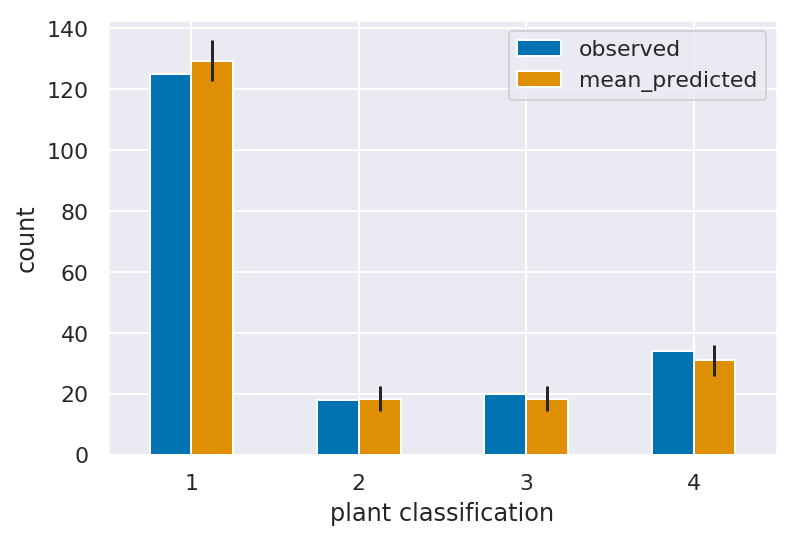

In [2]:
# observed data
y1, y2, y3, y4 = 125, 18, 20, 34
observed = [y1, y2, y3, y4]

# initial guess for theta^(0)
theta_old = 0.5

# M-step algorithm
eps = np.finfo(float).eps
iter_count, tol = 0, 1
while tol >= eps:
    C = theta_old / (2. + theta_old)
    theta_new = (C*y1 + y4) / (C*y1 + y2 + y3 + y4)
    tol = np.abs(theta_old - theta_new)
    theta_old = theta_new
    iter_count += 1

# simulate predictions
N = 197
N_bootstrap = 1_000
p = [theta_new/4. + 1./2., (1. - theta_new)/4., (1. - theta_new)/4., theta_new/4.]
preds = np.random.multinomial(N, p, N_bootstrap)
predicted, predicted_std  = np.mean(preds, axis=0), np.std(preds, axis=0)

# display
fig, ax = plt.subplots()
flower_results = {
    "observed": observed,
    "mean_predicted": predicted,
    "mean_predicted_std": predicted_std,
}
df = pd.DataFrame(flower_results)
df.index += 1
yerr = [0, 0, 0, 0], predicted_std
df.plot.bar(ax=ax, y=["observed", "mean_predicted"], rot=0, yerr=yerr)
ax.set_xlabel("plant classification")
ax.set_ylabel("count")

# print convergence results
print(f"number of iterations to convergence: {iter_count}")
print(f"theta^(m+1) = {theta_new}")

df

The algorithm is set to terminate after $\theta^{(m+1)}$ and $\theta^{(m)}$ are within machine precision of each other. To see how it did, the final $\theta^{(m+1)}$ found (printed above) was used to bootstrap `N_bootstrap` trials (orange) to compare against the observed data (blue). The results are also tabulated above.

### 1.4 Benefits of using EM step

Using this methodology, the MLE just became a maximization of expectation values, making the process more efficient and elegant in this case.



---

# Problem Description: Modeling Kidney Cancer Data
In this problem, we will work with the US Kidney Cancer Data set, `kcancer.csv`. This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

**In this homework, we focus on the mechanics of seting up a statistical model for this data set and performing inference on it. In the next homework, we will focus on interpreting this model and comparing it with others in context.**

Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}

where $\alpha, \beta$ are hyper-parameters of the model.


Rather than arbitrarily choosing the hyperparameters $\alpha, \beta$, following the Bayesian philosophy, we typically put additional priors on quantities of which we are uncertain. That is, we model the kidney cancer rates using a ***hierarchical model***:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Ga(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Ga(a, b)\\
\beta &\sim Ga(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 

In this problem, you will implement a modified Gibbs sampler to sample from the posterior of this complex model.



## Part I: The Conditional Distributions
1. Justify our choice to use a hierarchical model. Specifically, explain the draw-backs of using MLE estimates of $\theta_j$ to represent the underlying cancer rates of these counties (recall the discussion in Lecture #3). Explain the draw-backs of choosing specific values for the hyper-parameters of $\alpha$ and $\beta$ rather than putting priors on them (recall the discussion in Homework #1 about priors).<br><br>

2. Verify that the conditional distributions are 
\begin{align}
p(\theta_j | \theta_{-j}, y, \alpha, \beta) &= Ga(\theta_j; \alpha + y_j, 5 n_j  + \beta),\\
p(\alpha, \beta | \theta, y) &\propto \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} \left[\prod_j \theta_j^{\alpha - 1}\right] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}
\end{align}
  where we use the following notation:
\begin{align}
\theta &:= \{ \theta_j\}_{j=1, \ldots, N}\\
\theta_{-j} &:= \{ \theta_i\}_{i=1, \ldots, j-1, j+1,\ldots, N}\\
y &:= \{y_j \}_{j=1, \ldots, N}\\
y_{-j} &:= \{ y_i\}_{i=1,\ldots, j-1, j+1,\ldots, N}\\
\end{align}
  Unfortunately, you see that $p(\alpha, \beta | \theta, y)$ doesn't resemble the pdf of a nice simple distribution; that is, it is unclear how to sample from it.

### 2.1 Hierarchical model vs MLE

If the sample size is too small, the MLE can be overfitted (sensitive to outliers in the data), biased (average MLE over many samples is not the "true parameter estimate"), and imprecise (high variance). Putting priors on $\alpha$ and $\beta$ allow us to estimate out uncertainty in these parameters and update our beliefs as we gather more evidence.

### 2.2 Conditional distribution check

Starting with the first conditional, we know that the Poisson and Gamma distribution are conjugate priors of each other. Bayes theorem then tells us

\begin{align}
    p(\theta_j \| \theta_{-j}, y, \alpha, \beta) &\propto
    \frac{(5n_j\theta_j)^{y_j} e^{-5n_j\theta_j}}{y_j!}
    \times \frac{\beta^\alpha}{\Gamma(\alpha)}
    \theta^{\alpha - 1} e^{-\beta\theta_j} \\
    &= \frac{(5n_j)^{y_j}\beta^\alpha}{y_j!\Gamma(\alpha)}
    \theta_j^{\alpha + y_j - 1} e^{-(5n_j +\beta)\theta_j} \\
    &\propto
    \frac{(5n_j + \beta)^{\alpha + y_j}}{\Gamma(\alpha + y_j)}
    \theta_j^{\alpha + y_j - 1} e^{-(5n_j + \beta)\theta_j} \\
    &= \boxed{Ga(\theta_j; \alpha + y, 5n_j + \beta)} \quad.
\end{align}

Turning to the second conditional next, we have

\begin{align}
    p(\alpha, \beta \| \theta, y) &\propto
    \prod_{j=1}^N\left[ p(\theta \| \alpha, \beta) \right]
    p(\alpha \| a,b) p(\beta \| c, d) \\
    &= \prod_{j=1}^N \left[ 
    \left( 
    \frac{\beta^\alpha}{\Gamma(\alpha)}\theta_j^{\alpha - 1} 
    e^{-\beta\theta_j}
    \right)\right]
    \left( 
    \frac{b^a}{\Gamma(a)}\alpha^{a - 1}e^{-\alpha b}    
    \right)
    \left(
    \frac{d^c}{\Gamma(c)}\beta^{c-1}e^{-d\beta}    
    \right) \\
    &\propto
    \boxed{
    \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)}
    \left[ 
    \prod_{j=1}^N \theta_j^{\alpha - 1}    
    \right]
    e^{-\left(\sum_j^N \beta\theta_j\right) - d\beta - b\alpha}
    \alpha^{a - 1} \beta^{c - 1}
    } \quad.
\end{align}

## Part II: Metropolis-Hastings-in-Gibbs
1. When one or more conditional distributions in a Gibbs sampler do not have closed forms (this is the case for most models), we often sample from these conditionals using another MCMC method (e.g. Metropolis Hastings). That is, we modify the Gibbs sampler as follows:

  **I.** Sample $\theta_j$ using the closed form for $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$.
  
  **II.** Sample $\alpha, \beta$ from $p(\alpha, \beta | \theta, y)$ using a Metropolis-Hastings step (i.e. use a proposal distribution to propose a sample and the MH reject/accept mechanism to accept the new sample or keep the old).
  
  This algorithm is called a ***Metropolis-Hastings-in-Gibbs sampler***. <br><br>
  
  Note that we computed $p(\alpha, \beta | \theta, y)$ only up to a constant. Show why we don't need to know the normalizing constant of $p(\alpha, \beta | \theta, y)$ when we perform MH sampling.<br><br>
  
3.  Implement and run a Metropolis-Hastings-in-Gibbs sampler for the kidney cancer model.

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = 1.54517349188, \beta_0 = 133514.171939$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10<br><br>
  
4. Check for and discuss the convergence of your sampler. If you think your sampler has converged, explain why. If you believe your sampler has not converged, explain what next steps you might take to determine which design choices were problemmatic.
  
  **Important Disclaimer:** Convergence in a untweaked sampler may be unlikely after only 100,000 Gibbs sweeps. We are not asking you in this homework to achieve convergence, but you must demonstrate that you know how to perform diagnostics on your sampler.<br><br>
  
  
**Extra Credit:** Tweak the settings in your sampler (e.g. number of sweeps) in order to achieve reasonable confidence that your sampler has converged. Reconsider also other design choices like, do you need to sample $\alpha$ and $\beta$ jointly?<br><br>

**Extra Credit:** Prove the correctness of Metropolis-Hastings-in-Gibbs sampler. You need to state the definition of the correctness of an MCMC sampler and prove that Metropolis-Hastings-in-Gibbs sampler satisfy these properties.

### 3.1 Why we don't need the normalizing constant

In this sampling scheme, we break our complex hierarchical Bayesian model into two parts, an easy conditional distribution $(\theta_j \| \theta_{j-1},y,\alpha,\beta)$, and a hard one $(\alpha,\beta \| \theta, y)$. We then do the following: 

1. sample from the easy conditional
2. plug that into the hard conditional
3. sample from the hard conditional using a Metropolis-Hastings step

The last step is why we don't need to worry about the normalization constant on the hard conditional. According to the accept/reject criterion in the Metropolis-Hastings algorithim, it only depends on the ratio of the hard (target) conditional evaluated at the proposed step to the hard (target) conditional at the current step, so the factors cancel out!

### 3.2 M-H in Gibbs implementation

#### Data inspection

Let's do some data exploration real quick.

In [3]:
# load data
df = pd.read_csv("kcancer.csv")

print("first few entries:")
display(df.head())

print("\nsummary statistics:")
display(df.describe())

print("\ninvalid values check:")
df.isna().sum()

first few entries:


,state,fips,county,countyfips,dc,pop,pct_mortality
0,ALABAMA,1,AUTAUGA,1001,1.0,64915.0,0.000015
1,ALABAMA,1,BALDWIN,1003,15.0,195253.0,0.000077
2,ALABAMA,1,BARBOUR,1005,1.0,33987.0,0.000029
3,ALABAMA,1,BIBB,1007,1.0,31175.0,0.000032
4,ALABAMA,1,BLOUNT,1009,5.0,91547.0,0.000055



summary statistics:


,fips,countyfips,dc,pop,pct_mortality
count,3113.000000,3113.000000,3113.000000,3.113000e+03,3113.000000
mean,30.582396,30684.802441,8.351751,1.605124e+05,0.000058
std,14.963099,14981.306672,23.755474,4.970584e+05,0.000050
min,1.000000,1001.000000,0.000000,1.350000e+02,0.000000
25%,19.000000,19043.000000,1.000000,2.211900e+04,0.000028
50%,29.000000,29215.000000,3.000000,4.806200e+04,0.000052
75%,46.000000,46011.000000,7.000000,1.178920e+05,0.000077
max,56.000000,56045.000000,598.000000,1.660789e+07,0.000718



invalid values check:


state            0
fips             0
county           0
countyfips       0
dc               0
pop              0
pct_mortality    0
dtype: int64

Our data looks good (no missing values, weird headers, etc.), so let's go ahead and implement our sampler on the data as-is. The relevant columns look to be:

* `dc`: number of kidney cancer cases in each county $(y_j)$
* `pop`: population of each county $(n_j)$.

Working in log-space, our hard conditional now looks like

\begin{align}
    \ln p(\alpha,\beta \| \theta, y) = \sum_{i=1}^4 p_i \quad,
\end{align}

where

\begin{align}
    p_1 &= N\left( \alpha\ln\beta - \ln\Gamma(\alpha) \right) \quad, \\
    p_2 &= (\alpha - 1)\sum_{j=1}^N \ln\theta_j \quad, \\
    p_3 &= -\beta\sum_{j=1}^N(\theta_j) - d\beta - b\alpha \quad, \\
    p_4 &= (a - 1)\ln\alpha + (c - 1)\ln\beta \quad.
\end{align}

#### Implementation
We can now sample over this and the easy conditional in the Metropolis-Hastings-in-Gibbs implementation below.

In [11]:
params = {
    # system parameters
    'N': len(df), # Number of counties
    'y': df["dc"].to_numpy(), # number kidney cancer cases in each county
    'n': df["pop"].to_numpy(), # population of each county
    'a': 9, # p(alpha, beta | theta, y) parameters
    'b': 6,
    'c': 9,
    'd': 0.00001, 
    "Sigma": np.array([[0.1,     0.], # multivariate Gaussian proposal variance
                       [0.  , 1000.]]),
    # sampler parameters
    "iters":10_000, # sweeps
    #"init":[1.54517349188, 133514.171939], # [alpha_0, beta_0]
    "init":[10.84372735699656, 998150.723166988], # [alpha_0, beta_0]
}

# samples theta_j for each county from easy conditional
def theta_cond(step):
    y, n = [params[k] for k in ['y', 'n']]
    alpha, beta = step
    return np.random.gamma(alpha + y, 1./(5.*n + beta))

# hard conditional
def log_p_alpha_beta_given_theta_y(step, theta_cond):
    a, b, c, d, N = [params[k] for k in ['a', 'b', 'c', 'd', 'N']]
    alpha, beta = step
    p1 = N*(alpha*np.log(beta) - np.log(st.special.gamma(alpha)))
    p2 = (alpha - 1.)*np.sum(np.log(theta_cond))
    p3 = -beta*np.sum(theta_cond) - d*beta - b*alpha
    p4 = (a - 1.)*np.log(alpha) + (c - 1.)*np.log(beta)
    return np.sum([p1, p2, p3, p4])
log_cond_hard = log_p_alpha_beta_given_theta_y

# proposal step to take 
def draw_proposal(step):
    Sigma = params["Sigma"]
    return np.random.multivariate_normal(step, Sigma)

# distribution proposal step is drawn from
def log_proposal(mu, x): 
    Sigma = params["Sigma"]
    return -0.5 * (x - mu).T.dot(np.linalg.inv(Sigma)).dot(x - mu)

#implementation of the M-H in Gibbs sampler
sampler_params = {k:params[k] for k in ["init", "iters"]}
def mh_in_gibbs(cond_easy, log_cond_hard, draw_proposal, log_proposal, init, iters):
    step_current = init
    samples = [step_current]
    accept_count = 0
    for i in range(iters):
        # directly sample from easy conditional
        cond_easy_vals = cond_easy(step_current)

        # plug sample into hard conditional and take Metropolis-Hastings step
        #step_proposal = np.random.multivariate_normal(step_current, Sigma)
        #log_proposal = lambda mu, x: -0.5 * (x - mu).T.dot(np.linalg.inv(Sigma)).dot(x - mu)
        log_U = np.log(np.random.uniform(0, 1))
        step_proposal = draw_proposal(step_current)
        log_alpha = (log_cond_hard(step_proposal, cond_easy_vals) -
                     log_proposal(step_current, step_proposal) -
                     log_cond_hard(step_current, cond_easy_vals) +
                     log_proposal(step_proposal, step_current))
        
        # take a step
        if log_U <= np.min((0, log_alpha)):
            step_current = step_proposal
            accept_count += 1
        else:
            pass
        
        # save results
        samples.append(step_current)
    return np.array(samples), 100.*(accept_count / iters)

# run
start = time.clock()
samples, accept_rate = mh_in_gibbs(theta_cond, log_cond_hard, draw_proposal, log_proposal,
                                   **sampler_params)
end = time.clock() - start

# print results
print(f"Sampling completed in {end:.2f} seconds")
print(f"Acceptance rate: {accept_rate:.1f}%")
print(f"(alpha, beta) = {samples[-1][0], samples[-1][1]}\n")
print("System and Sampler parameters")
print("-----------------------------")
for k, v in params.items():
    print(f"{k}: {v}")

Sampling completed in 23.04 seconds
Acceptance rate: 21.7%
(alpha, beta) = (10.707086766423952, 996965.4381858377)

System and Sampler parameters
-----------------------------
N: 3113
y: [ 1. 15.  1. ...  1.  2.  0.]
n: [ 64915. 195253.  33987. ...  52910.  22814.  17802.]
a: 9
b: 6
c: 9
d: 1e-05
Sigma: [[1.e-01 0.e+00]
 [0.e+00 1.e+03]]
iters: 10000
init: [10.84372735699656, 998150.723166988]


### 3.3 Convergence discussion

One way we can check to see if our sampler converged is by looking at the samples in the parameter space $(\alpha, \beta)$ and checking visually if the samples are converging to a single location.

We can also look at the samples of $\alpha$ and $\beta$ individually by looking at their trace. Note: the phase space plot starts at the circle and end at the 'x'.

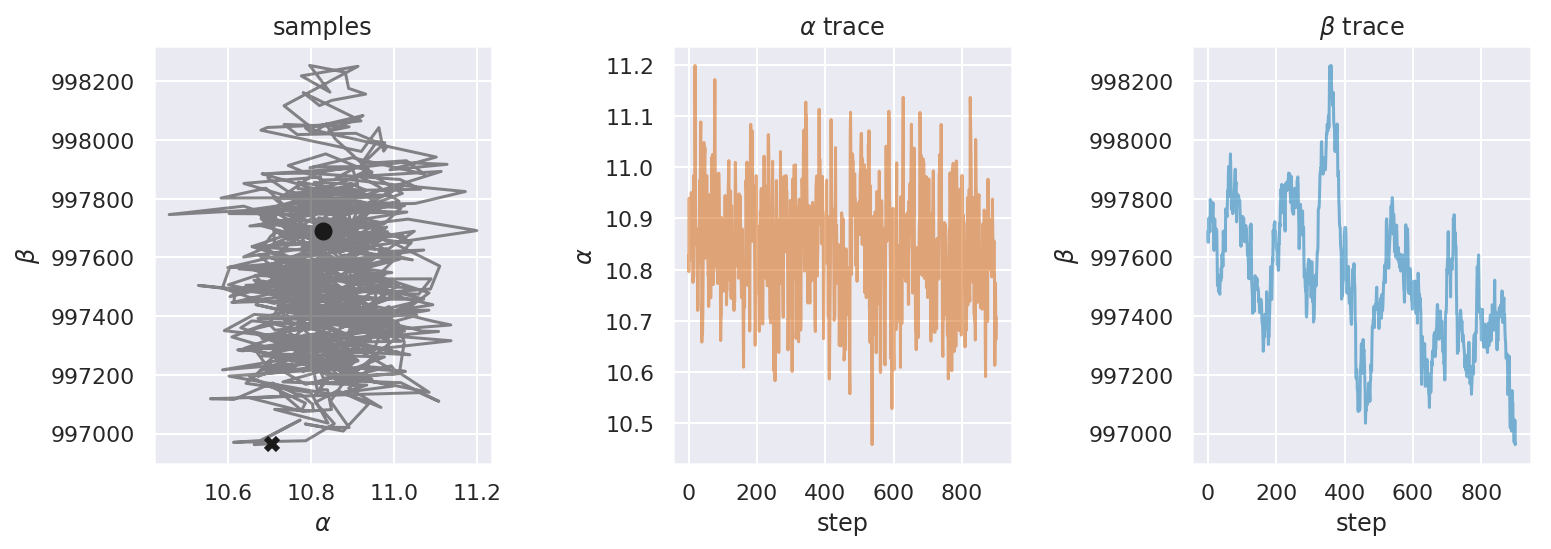

In [12]:
# burn and thin
burn = 10 # ignore first `burn`% of samples
thin = 10 # keep every `thin` samples
samples_reduced = samples[int((burn/100.)*params['iters'])::thin, :]
alpha, beta = samples_reduced[:, 0], samples_reduced[:, 1]

# plot
fig, axes = plt.subplots(1, 3, figsize=fig_wide)

# (alpha, beta) phase plot
axes[0].plot(alpha, beta, "k", alpha=0.5)
axes[0].plot(alpha[0], beta[0], "ko", mew=3)
axes[0].plot(alpha[-1], beta[-1], "kx", mew=3)
axes[0].set_xlabel(r"$\alpha$")
axes[0].set_ylabel(r"$\beta$")
axes[0].set_title("samples")

# alpha trace
axes[1].plot(alpha, "r", alpha=0.5)
axes[1].set_xlabel("step")
axes[1].set_ylabel(r"$\alpha$")
axes[1].set_title(r"$\alpha$ trace")

# beta trace
axes[2].plot(beta, 'b', alpha=0.5)
axes[2].set_xlabel("step")
axes[2].set_ylabel(r"$\beta$")
axes[2].set_title(r"$\beta$ trace")

fig.tight_layout()

After 100,000 iterations at least, it seems that $\alpha$ is slowly starting to converge while $\beta$ continues to increase without bound. It might help to sample $\alpha$ and $\beta$ separately. It may also be helpful to check for auto-correlation between $\alpha$ and $\beta$, run for more iterations, or try a wider variance on $\alpha$ and/or $\beta$ in the proposal distribution's covariance matrix to try and better explore the parameter space.

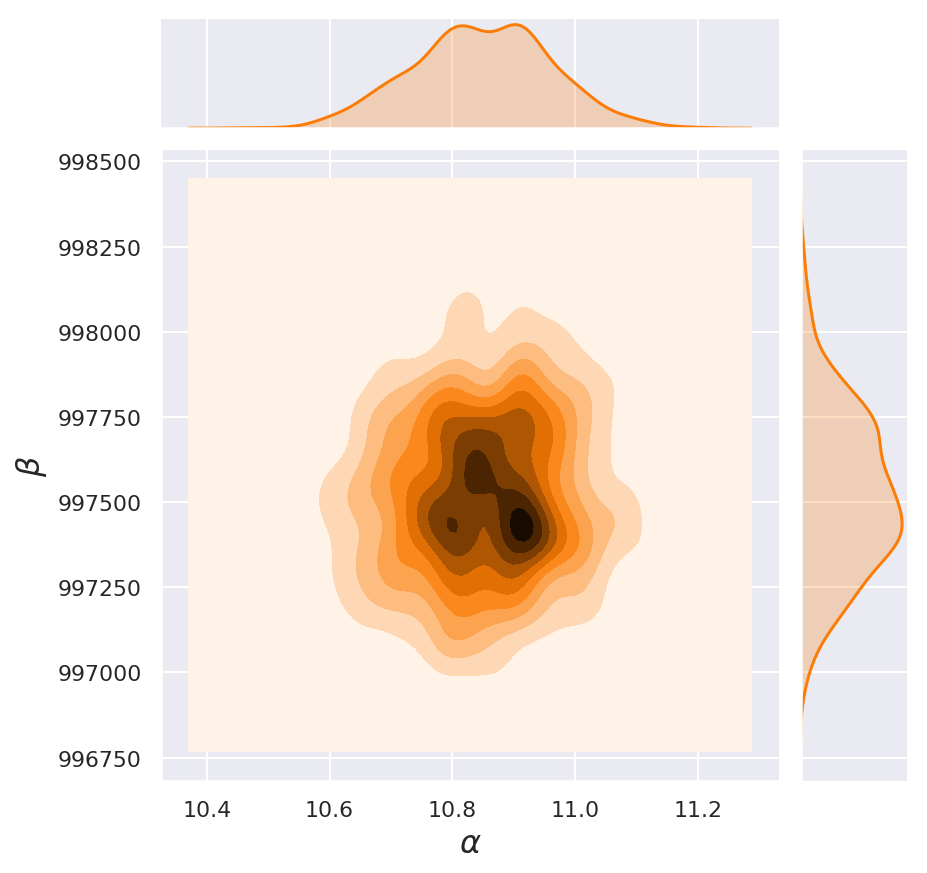

In [14]:
p = sns.jointplot(alpha, beta, kind="kde", color="#fb7d07")
p.set_axis_labels(r"$\alpha$", r"$\beta$", fontsize=16)